Computational Neurophysiology Laboratory, Brain Institute, UFRN, Brazil<br>
Rodrigo MM Santiago<br>
2023

# Dentate spike detection

### Function import

**Custom functions**

In [1]:
import dentatespike as ds

**Scientific modules and functions**

In [2]:
import emd                                   # empirical mode decomposition
import numpy as np                           # numerical operations
import pickle                                # for data saving
from scipy.signal import welch               # power spectral density estimation

# for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

### Data loading

Data available at https://buzsakilab.nyumc.org/datasets/SenzaiY/YutaMouse21/YutaMouse21-140611/

In [3]:
path         = '/home/rsantiago/Senzai/'           # path to file
session_name = 'YutaMouse21-140611'                # session file name
LFP,srate    = ds.signal.getLFP(path+session_name) # LFP and sampling rate

In [4]:
print(LFP.shape)
print(srate)

(16, 42189125)
1250.0


### LFP downsampling

In [5]:
new_srate    = 1000.                                          # new sampling rate (Hz)
LFP          = ds.signal.resampleLFP(LFP,srate,new_srate)     # LFP downsampling
srate        = new_srate; del new_srate                       # update of the sampling rate variable
LFP          = LFP/1e3                                        # LFP unit transformation to mV
nCh          = len(LFP)                                       # number of LFP channels
time_vector  = np.linspace(0,(len(LFP[0])/srate),len(LFP[0])) # LFP time vector (s)

Processing elapsed time: 5.19 min.


In [6]:
print(LFP.shape)
print(srate)

(16, 33751300)
1000.0


### LFP plotting

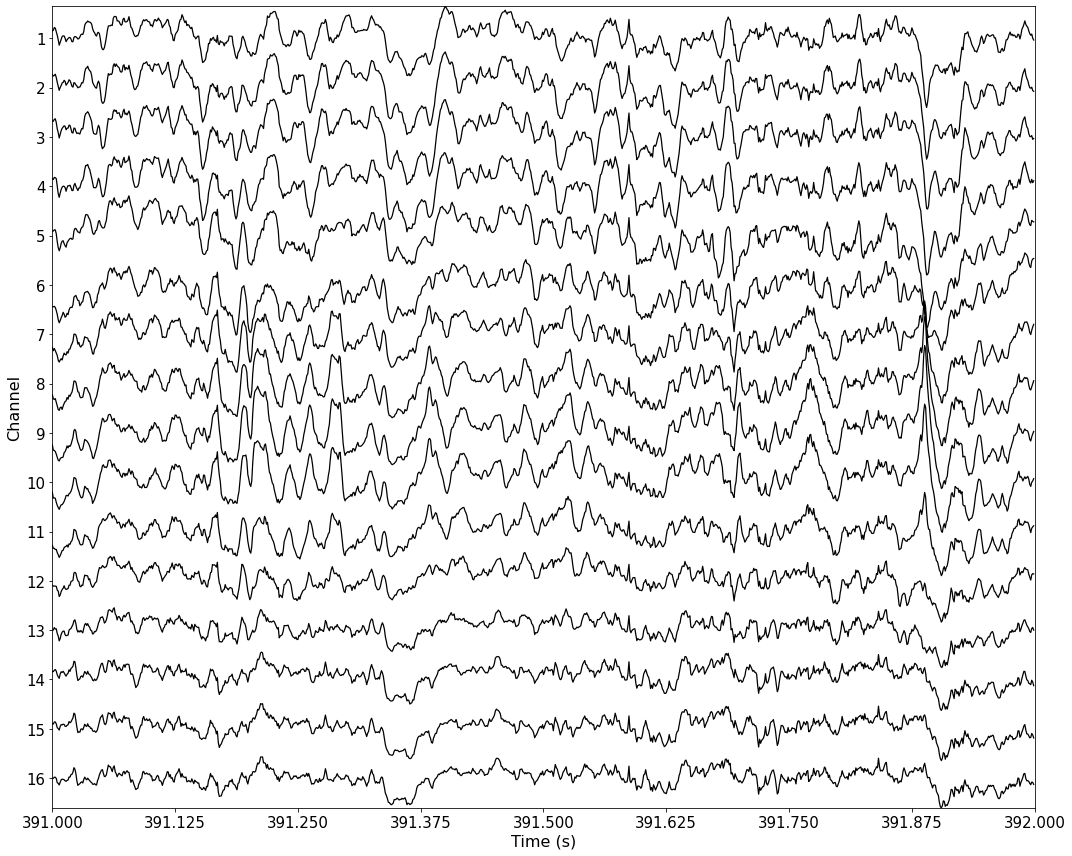

In [7]:
startT   = 391 # start time (s)
windowT  = 1   # time window length (s)
lfpshift = 1.1 # vertical shift between neighboring channels (mV)

plt.figure(figsize=(15,12))
ds.signal.plotLFP(time_vector,LFP,startT,windowT,lfpshift)

### DS detection

In [8]:
ch     = 8  # most prominent DS channel (target channel)
ref_ch = 15 # reference channel

DS_ind,DS_waveforms,t_waveform,offset,DS_waveforms_ = ds.detection.detectDS(LFP,ch,refch=ref_ch)
print('Number of detected events:',str(len(DS_ind)))

Number of detected events: 8098


DS peak offset correction:

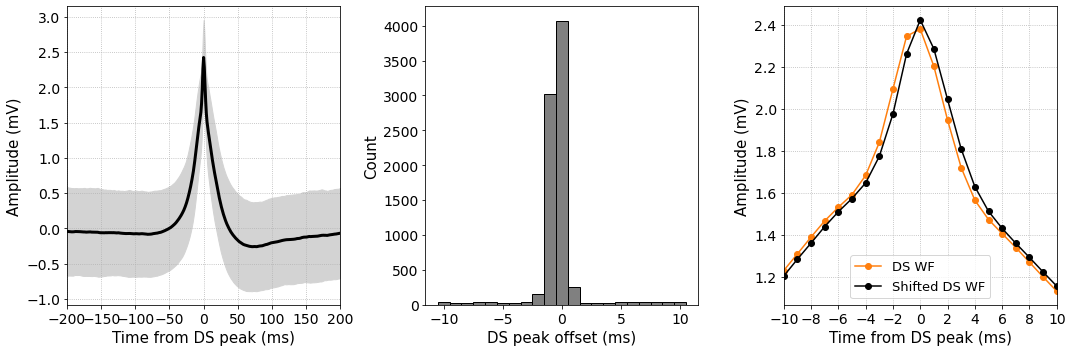

In [9]:
plt.figure(figsize=(15,5))

plt.subplot(131)
DS_waveforms_mean = np.mean(DS_waveforms,axis=0)
DS_waveforms_sd   = np.std(DS_waveforms,axis=0)

plt.fill_between(t_waveform,DS_waveforms_mean-DS_waveforms_sd,DS_waveforms_mean+DS_waveforms_sd,
                 color='lightgrey')
plt.plot(t_waveform,DS_waveforms_mean,'k',lw=3)
plt.xlabel('Time from DS peak (ms)',size=15)
plt.ylabel('Amplitude (mV)',size=15)
plt.xticks(size=14)
plt.yticks(size=14)
plt.autoscale(enable=True,axis='x',tight=True)
plt.grid(linestyle='dotted');

plt.subplot(132)
plt.hist(offset,np.arange(-10.5,10.6,1),color='grey',ec='k');
plt.xlabel('DS peak offset (ms)',size=15)
plt.ylabel('Count',size=15)
plt.xticks(size=14)
plt.yticks(size=14)

plt.subplot(133)
t_win = (t_waveform>=-10)*(t_waveform<=10)
plt.plot(t_waveform[t_win],np.mean(DS_waveforms_,axis=0)[t_win],'-o',color='C1',label='DS WF')
plt.plot(t_waveform[t_win],np.mean(DS_waveforms,axis=0)[t_win],'-o',color='k',label='Shifted DS WF')
plt.xlabel('Time from DS peak (ms)',size=15)
plt.ylabel('Amplitude (mV)',size=15)
plt.xticks(size=14)
plt.yticks(size=14)
plt.autoscale(enable=True,axis='x',tight=True)
plt.legend(fontsize=13)
plt.grid(linestyle='dotted');
plt.xticks(np.arange(-10,10.1,2));

plt.tight_layout();

### DS rate in function of the power of delta oscillations

**Empirical Mode Decomposition**

In [10]:
# Intrinsic Mode Functions
IMFs = emd.sift.sift(LFP[ch]).T

In [11]:
# Parameters for power spectrum density
windowlen = 4.*srate     # window length
overlap   = windowlen/2. # overlap length
nfft      = 2.**14       # number of FFTs

In [12]:
# Power spectrum density of each IMF
IMFs_PSD = np.array([welch(IMF,fs=srate,nperseg=windowlen,noverlap=overlap,nfft=nfft) for IMF in IMFs])

F        = IMFs_PSD[0,0,:] # frequencies
IMFs_PSD = IMFs_PSD[:,1,:] # PSDs

IMF-5 comprises delta frequency

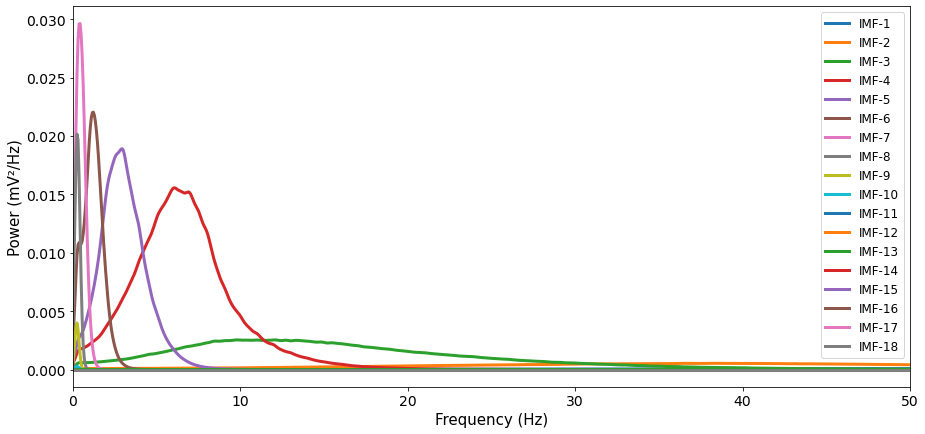

In [13]:
plt.figure(figsize=(15,7))
for i,IMF_PSD in enumerate(IMFs_PSD):
    plt.plot(F,IMF_PSD,label=f'IMF-{i+1}',lw=3);
plt.xlim(0,50);
plt.xlabel('Frequency (Hz)',size=15)
plt.ylabel('Power (mV²/Hz)',size=15)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=12);

Number of DSs in each 1-min window in function to the relative delta power

In [14]:
# General parameters
epoch_min      = 1        # time interval (in minutes)
delta_range    = [0., 5.] # delta frequency range (in Hz)
detectDSperBin = False    # DSs are detected considering the whole LFP

In [15]:
t_delta,rel_delta_power,n_DSs,PSD_all,PSD_high,PSD_low,F = ds.analysis.DSRateDeltaPower(IMFs[4],LFP,epoch_min,
                                                                                         srate,delta_range,ch,
                                                                                         ref_ch,detectDSperBin)

Processing elapsed time: 0.36 min.


In [16]:
# Delta indexes in the frequency array
delta_idx = (F>=0)*(F<=delta_range[1])

# Ranges of weak and strong delta
bin_ranges = np.array([[np.min(rel_delta_power)-.1,0.9],[0.9,np.max(rel_delta_power)+.1]])

In [17]:
# Variables for boxplots
n_DSs_per_ratio_bin,quartile1,quartile3,medians = ds.analysis.DSperRelDelta(rel_delta_power,n_DSs,
                                                                             PSD_all,bin_ranges)

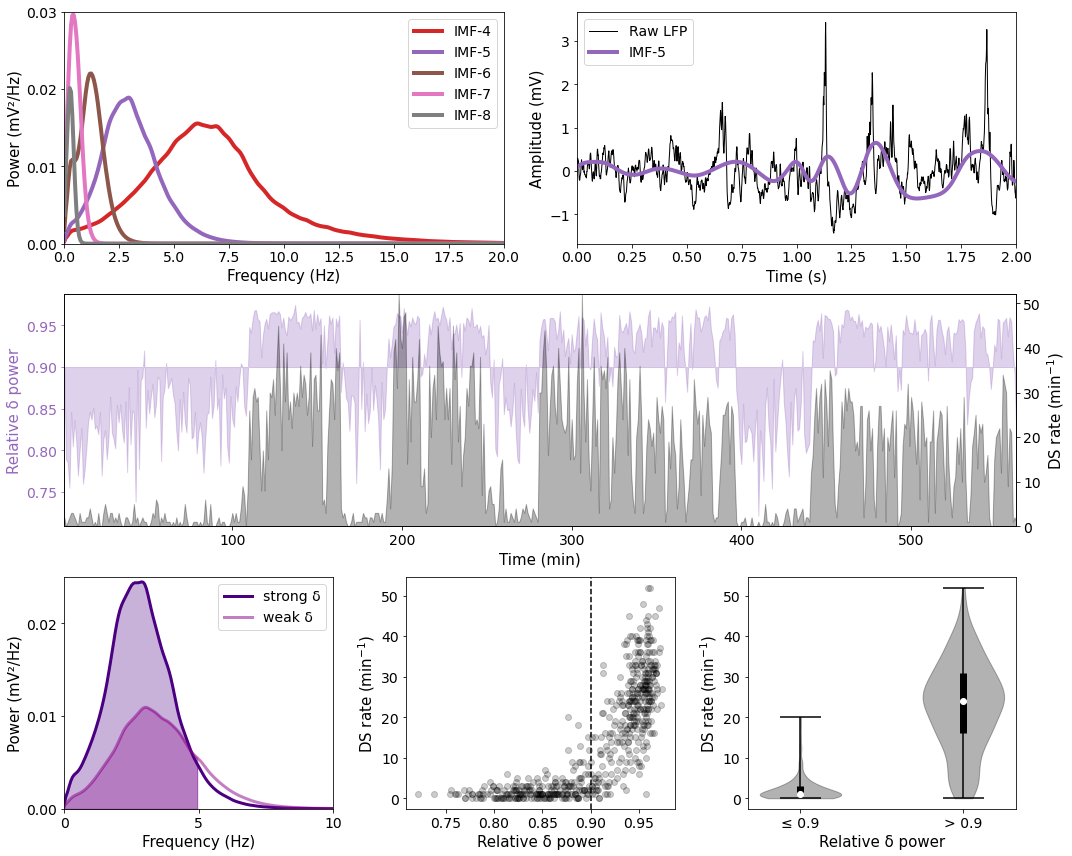

In [18]:
plt.figure(figsize=(15,12))

plt.subplot(3,6,(1,3))
for i,IMF_PSD in enumerate(IMFs_PSD[3:8]):
    plt.plot(F,IMF_PSD,label=f'IMF-{i+4}',lw=4,c=f'C{i+3}');
plt.xlim(0,20)
plt.ylim(0,0.03)
plt.xlabel('Frequency (Hz)',size=15)
plt.ylabel('Power (mV²/Hz)',size=15)
plt.xticks(size=14)
plt.yticks([0,0.01,0.02,0.03],size=14)
plt.legend(fontsize=14)

plt.subplot(3,6,(4,6))
t_ = np.linspace(0,2,2000)
start_min = 111.062
start_id = int(start_min*60*srate)
end_id   = start_id+int(2*srate)
plt.plot(t_,LFP[8][start_id:end_id],c='k',lw=1,label='Raw LFP')
plt.plot(t_,IMFs[4][start_id:end_id],c='C4',lw=4,label='IMF-5')
plt.legend(fontsize=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel('Time (s)',size=15)
plt.ylabel('Amplitude (mV)',size=15)
plt.autoscale(axis='x',tight=True)

ax1 = plt.subplot(3,6,(7,12))
ax1.fill_between(t_delta,rel_delta_power,0.9,color='C4',alpha=0.3)
ax2 = ax1.twinx()
ax2.fill_between(t_delta,n_DSs,color='k',alpha=0.3)
ax1.set_ylabel('Relative δ power',size=15, color='C4')
ax2.set_ylabel('DS rate (min$^{-1}$)',size=15, color='k')
ax1.set_xlabel('Time (min)',size=15)
ax1.tick_params(axis='y', colors='C4',labelsize=14, color='C4')
ax1.tick_params(axis='x',labelsize=14)
ax2.tick_params(axis='y',labelsize=14)
ax2.set_ylim(0,np.max(n_DSs))
ax1.autoscale(axis='x',tight=True)

plt.subplot(3,6,(13,14))
PSD_high_m = np.mean(PSD_high,axis=0)
PSD_low_m = np.mean(PSD_low,axis=0)
plt.plot(F,PSD_high_m,label='strong δ',lw=3,c='indigo')
plt.fill_between(F[delta_idx],PSD_high_m[delta_idx],alpha=0.3,color='indigo')
plt.plot(F,PSD_low_m,label='weak δ',lw=3,c='darkmagenta',alpha=0.5);
plt.fill_between(F[delta_idx],PSD_low_m[delta_idx],alpha=0.3,color='darkmagenta')
plt.xlim(0,10);
plt.ylim(0,0.025);
plt.xlabel('Frequency (Hz)',size=15)
plt.ylabel('Power (mV²/Hz)',size=15)
plt.xticks([0,5,10],size=14)
plt.yticks([0,0.01,0.02],size=14)
plt.legend(fontsize=14)

plt.subplot(3,6,(15,16))
plt.scatter(rel_delta_power,n_DSs,color='k',alpha=0.2)
plt.axvline(x=.9,color='k',ls='--')
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel('Relative δ power',size=15)
plt.ylabel('DS rate (min$^{-1}$)',size=15)

plt.subplot(3,6,(17,18))
violin_parts = plt.violinplot(n_DSs_per_ratio_bin,showextrema=True)
for pc in violin_parts['bodies']:
    pc.set_color('k')
violin_parts['cbars'].set_color('k')
violin_parts['cmins'].set_color('k')
violin_parts['cmaxes'].set_color('k')
inds = np.arange(1,len(medians)+1)
plt.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=7)
plt.plot(inds,medians,'ow');
plt.xticks(inds,['≤ 0.9','> 0.9'],size=14)
plt.yticks(size=14)
plt.xlabel('Relative δ power',size=15)
plt.ylabel('DS rate (min$^{-1}$)',size=15)

plt.tight_layout();

### Data saving

In [19]:
pickle.dump(LFP,open("LFP.txt","wb"))
pickle.dump(srate,open("srate.txt","wb"))
pickle.dump(DS_ind,open("DS_ind.txt","wb"))
pickle.dump(DS_waveforms,open("DS_waveforms.txt","wb"))
pickle.dump(t_waveform,open("t_waveform.txt","wb"))